In [476]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

In [506]:
batch_size=64
SIZE=32

In [507]:
def random_contrast_adjustment(img, lower=1.5, upper=1.8):
 
    # Genera un factor de contraste aleatorio dentro del rango dado
    contrast_factor = np.random.uniform(lower, upper)
    
    # Calcula el promedio de la imagen para ajustar el contraste
    mean = np.mean(img)
    
    # Ajusta el contraste de la imagen
    contrasted_img = (img - mean) * contrast_factor + mean
    
    # Asegura que los valores de la imagen sigan estando en el rango válido
    contrasted_img = np.clip(contrasted_img, 0, 255)
    return contrasted_img

def convert_to_grayscale(img):
    # Convertir a escala de grises promediando los canales de color
    return np.mean(img, axis=-1, keepdims=True)

def custom_preprocessing(img):
    #img = convert_to_grayscale(img)   # Convierte la imagen a escala de grises
    img = random_contrast_adjustment(img)
    img = (img / 127.5) - 1.0  # Normalizar a [-1, 1]
    return img


def load_images_from_directory(directory, class_name, img_size=(SIZE, SIZE), batch_size=32):
    datagen = ImageDataGenerator(
        preprocessing_function=custom_preprocessing,  # Usa la función de preprocesamiento definida previamente
        horizontal_flip=True,  # Habilita el espejado horizontal
        vertical_flip=True,    # Habilita el espejado vertical
        #rotation_range=10,     # Rotaciones leves
        brightness_range=[1,1.2],  # Cambios en brillo
        zoom_range=0.2         # Zooms leves
    )

    dataset = datagen.flow_from_directory(
        directory,
        classes=[class_name],
        target_size=img_size,  # Tamaño de imagen
        batch_size=batch_size,  # Tamaño del lote
        class_mode=None,        # Autoencoders no necesitan etiquetas
        shuffle=True            # Mezcla las imágenes
    )

    return dataset

source_directory = 'Dataset/animal_cutouts'
class_folder = 'seacucumber'

img_size = (SIZE, SIZE)  # Ajusta según sea necesario

# Carga las imágenes
image_generator = load_images_from_directory(source_directory, class_folder, batch_size=batch_size, img_size=img_size)


Found 3179 images belonging to 1 classes.


(32, 32, 3)


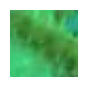

In [508]:
# Trama 4 imágenes
plt.figure(figsize=(4, 4))

# Obtiene un lote de imágenes
batch = next(image_generator)
print(batch[0].shape)

for i in range(1):
    img = batch[i]
    plt.subplot(1, 4, i+1)
    plt.imshow((img + 1) / 2)  # Deshacer la normalización para mostrar la imagen correctamente
    plt.axis('off')
plt.show()


In [529]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, LeakyReLU, Conv2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D, Conv2D
import keras

def build_generator(latent_dim=100):
    model = Sequential()

    model.add(Dense(4*4*128,activation="relu",input_dim=100))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization())
   

    return model

In [574]:
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, LeakyReLU, Conv2D, Activation, Flatten, Dense, Reshape
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Activation, Concatenate
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Activation, ZeroPadding2D
def build_discriminator(in_shape=(SIZE,SIZE,3)):
    model = Sequential()

    model.add(Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]))



    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [575]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.5) 
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=4e-3, beta_1=0.5)

In [576]:
generator = build_generator()
generator.summary()
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 2048)              206848    
                                                                 
 reshape_56 (Reshape)        (None, 4, 4, 128)         0         
                                                                 
 batch_normalization_323 (Ba  (None, 4, 4, 128)        512       
 tchNormalization)                                               
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 8, 8, 128)        262272    
 Transpose)                                                      
                                                                 
 batch_normalization_324 (Ba  (None, 8, 8, 128)        512       
 tchNormalization)                                               
                                                    

In [577]:
@tf.function
def train_step(images):
  seed = tf.random.normal([batch_size, 100])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [578]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    # Adjust the figure size if needed
    fig = plt.figure(figsize=(2, 2))

    # Limit to display the first 4 images
    for i in range(4):  # Change from `predictions.shape[0]` to `4`
        plt.subplot(2, 2, i+1)  # Arrange in a 2x2 grid
        # Change the indexing to access the correct color channels.
        # Assuming the generated images are RGB (3 channels),
        # you need to show all three channels
        image = np.clip(predictions[i, :, :, :] * 127.5 + 127.5, 0, 255).astype(np.uint8)
        plt.imshow(image,cmap='gray')
        plt.axis('off')

    # Save and display the figure
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [579]:
from tqdm import tqdm  # Import tqdm
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, 100])

def train(dataset, epochs, batch_size=4):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        # Calcula el número de pasos por época
        steps_per_epoch = dataset.samples // batch_size
        if dataset.samples % batch_size != 0:
            steps_per_epoch += 1

        # tqdm se utiliza aquí para mostrar la barra de progreso
        with tqdm(total=steps_per_epoch, desc=f'Epoch {epoch + 1}/{epochs}', unit='step') as pbar:
            for step in range(steps_per_epoch):
                # Extrae sólo las imágenes del batch
                image_batch = next(dataset)
                t_loss_gen, t_loss_disc = train_step(image_batch)
                gen_loss_list.append(t_loss_gen)
                disc_loss_list.append(t_loss_disc)

                # Actualiza la barra de progreso
                pbar.update(1)

            # Genera imágenes para el GIF al final
            generate_and_save_images(generator, epoch + 1, seed)

            # Opcionalmente guarda el modelo cada 15 épocas
            # if (epoch + 1) % 15 == 0:
                # checkpoint.save(file_prefix=checkpoint_prefix)

        # Imprime las pérdidas después de la barra de progreso
        print(f'Generator Loss: {np.mean(gen_loss_list)}, Discriminator Loss: {np.mean(disc_loss_list)}')


Epoch 1/1000: 100%|██████████| 50/50 [00:07<00:00,  9.90step/s]

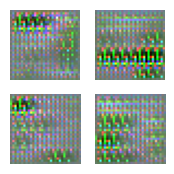

Epoch 1/1000: 100%|██████████| 50/50 [00:07<00:00,  6.46step/s]


Generator Loss: 36.50835037231445, Discriminator Loss: 2.2164597511291504


Epoch 2/1000: 100%|██████████| 50/50 [00:05<00:00,  9.48step/s]

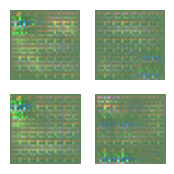

Epoch 2/1000: 100%|██████████| 50/50 [00:05<00:00,  9.18step/s]


Generator Loss: 33.05198669433594, Discriminator Loss: 1.3654006719589233


Epoch 3/1000: 100%|██████████| 50/50 [00:04<00:00,  9.82step/s]

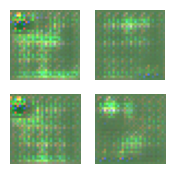

Epoch 3/1000: 100%|██████████| 50/50 [00:05<00:00,  9.67step/s]


Generator Loss: 9.923422813415527, Discriminator Loss: 0.6645974516868591


Epoch 4/1000: 100%|██████████| 50/50 [00:05<00:00, 10.83step/s]

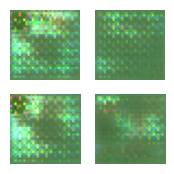

Epoch 4/1000: 100%|██████████| 50/50 [00:05<00:00,  8.96step/s]


Generator Loss: 10.333294868469238, Discriminator Loss: 0.2768051028251648


Epoch 5/1000: 100%|██████████| 50/50 [00:05<00:00,  9.31step/s]

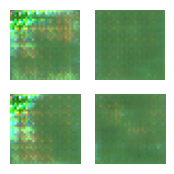

Epoch 5/1000: 100%|██████████| 50/50 [00:05<00:00,  8.99step/s]


Generator Loss: 6.081809043884277, Discriminator Loss: 0.5687401294708252


Epoch 6/1000: 100%|██████████| 50/50 [00:05<00:00,  7.95step/s]

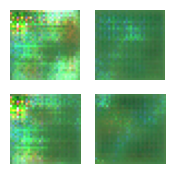

Epoch 6/1000: 100%|██████████| 50/50 [00:05<00:00,  9.60step/s]


Generator Loss: 5.665688991546631, Discriminator Loss: 0.35344815254211426


Epoch 7/1000:  98%|█████████▊| 49/50 [00:04<00:00, 11.31step/s]

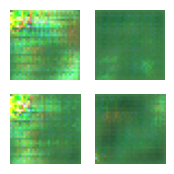

Epoch 7/1000: 100%|██████████| 50/50 [00:04<00:00, 10.23step/s]


Generator Loss: 4.061796188354492, Discriminator Loss: 0.4769819676876068


Epoch 8/1000: 100%|██████████| 50/50 [00:04<00:00, 10.40step/s]

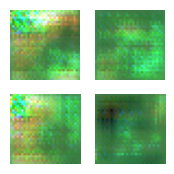

Epoch 8/1000: 100%|██████████| 50/50 [00:04<00:00, 10.56step/s]


Generator Loss: 4.488832473754883, Discriminator Loss: 0.4996359646320343


Epoch 9/1000:  98%|█████████▊| 49/50 [00:04<00:00, 11.64step/s]

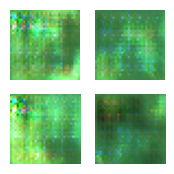

Epoch 9/1000: 100%|██████████| 50/50 [00:04<00:00, 10.97step/s]


Generator Loss: 4.595233917236328, Discriminator Loss: 0.7714476585388184


Epoch 10/1000:  98%|█████████▊| 49/50 [00:04<00:00, 11.90step/s]

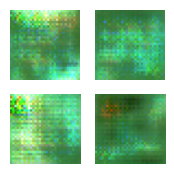

Epoch 10/1000: 100%|██████████| 50/50 [00:04<00:00, 10.85step/s]


Generator Loss: 5.008707523345947, Discriminator Loss: 0.7185052633285522


Epoch 11/1000:  98%|█████████▊| 49/50 [00:04<00:00,  9.89step/s]

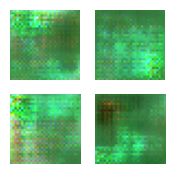

Epoch 11/1000: 100%|██████████| 50/50 [00:05<00:00,  9.87step/s]


Generator Loss: 4.625764846801758, Discriminator Loss: 0.6181803345680237


Epoch 12/1000:  98%|█████████▊| 49/50 [00:04<00:00, 11.66step/s]

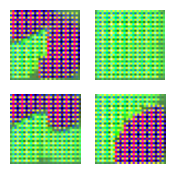

Epoch 12/1000: 100%|██████████| 50/50 [00:04<00:00, 10.27step/s]


Generator Loss: 1157.8634033203125, Discriminator Loss: 976.6437377929688


Epoch 13/1000: 100%|██████████| 50/50 [00:04<00:00, 10.03step/s]

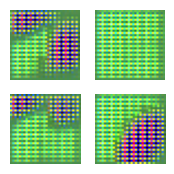

Epoch 13/1000: 100%|██████████| 50/50 [00:05<00:00,  9.84step/s]


Generator Loss: 64.29065704345703, Discriminator Loss: 7.684555530548096


Epoch 14/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.76step/s]

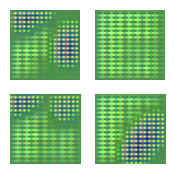

Epoch 14/1000: 100%|██████████| 50/50 [00:04<00:00, 10.36step/s]


Generator Loss: 70.53584289550781, Discriminator Loss: 4.854885101318359


Epoch 15/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.15step/s]

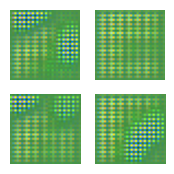

Epoch 15/1000: 100%|██████████| 50/50 [00:05<00:00,  9.91step/s]


Generator Loss: 82.73800659179688, Discriminator Loss: 1.1195266246795654


Epoch 16/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.28step/s]

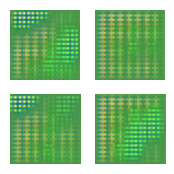

Epoch 16/1000: 100%|██████████| 50/50 [00:05<00:00,  9.51step/s]


Generator Loss: 68.07316589355469, Discriminator Loss: 4.681664943695068


Epoch 17/1000: 100%|██████████| 50/50 [00:05<00:00,  7.87step/s]

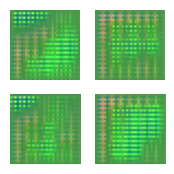

Epoch 17/1000: 100%|██████████| 50/50 [00:05<00:00,  8.48step/s]


Generator Loss: 68.22802734375, Discriminator Loss: 3.8090593814849854


Epoch 18/1000:  98%|█████████▊| 49/50 [00:04<00:00, 12.14step/s]

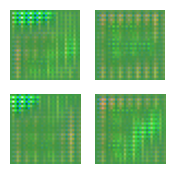

Epoch 18/1000: 100%|██████████| 50/50 [00:04<00:00, 10.10step/s]


Generator Loss: 110.85551452636719, Discriminator Loss: 2.0933728218078613


Epoch 19/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.44step/s]

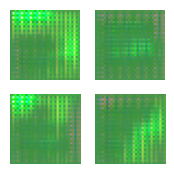

Epoch 19/1000: 100%|██████████| 50/50 [00:05<00:00,  9.46step/s]


Generator Loss: 68.22368621826172, Discriminator Loss: 3.590938091278076


Epoch 20/1000: 100%|██████████| 50/50 [00:04<00:00, 11.64step/s]

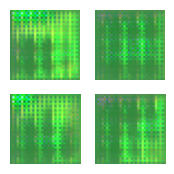

Epoch 20/1000: 100%|██████████| 50/50 [00:05<00:00,  9.89step/s]


Generator Loss: 53.98392105102539, Discriminator Loss: 8.044595718383789


Epoch 21/1000: 100%|██████████| 50/50 [00:04<00:00, 11.36step/s]

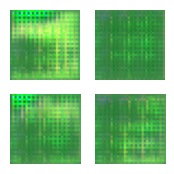

Epoch 21/1000: 100%|██████████| 50/50 [00:04<00:00, 10.78step/s]


Generator Loss: 38.12162399291992, Discriminator Loss: 4.423971176147461


Epoch 22/1000:  98%|█████████▊| 49/50 [00:04<00:00,  9.97step/s]

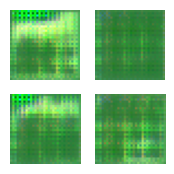

Epoch 22/1000: 100%|██████████| 50/50 [00:05<00:00,  9.77step/s]


Generator Loss: 26.854459762573242, Discriminator Loss: 4.188283443450928


Epoch 23/1000: 100%|██████████| 50/50 [00:04<00:00,  9.86step/s]

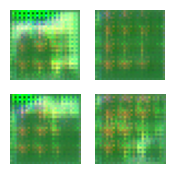

Epoch 23/1000: 100%|██████████| 50/50 [00:05<00:00,  9.77step/s]


Generator Loss: 19.86273193359375, Discriminator Loss: 3.1837635040283203


Epoch 24/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.47step/s]

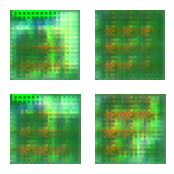

Epoch 24/1000: 100%|██████████| 50/50 [00:05<00:00,  9.51step/s]


Generator Loss: 18.4301815032959, Discriminator Loss: 2.7393200397491455


Epoch 25/1000: 100%|██████████| 50/50 [00:05<00:00,  9.05step/s]

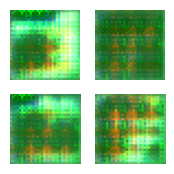

Epoch 25/1000: 100%|██████████| 50/50 [00:05<00:00,  8.94step/s]


Generator Loss: 16.340944290161133, Discriminator Loss: 1.7497620582580566


Epoch 26/1000: 100%|██████████| 50/50 [00:05<00:00,  9.38step/s]

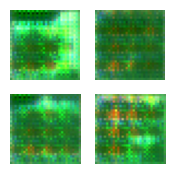

Epoch 26/1000: 100%|██████████| 50/50 [00:06<00:00,  8.29step/s]


Generator Loss: 16.041522979736328, Discriminator Loss: 1.5561294555664062


Epoch 27/1000: 100%|██████████| 50/50 [00:05<00:00,  8.26step/s]

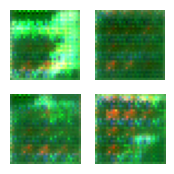

Epoch 27/1000: 100%|██████████| 50/50 [00:05<00:00,  8.48step/s]


Generator Loss: 17.296640396118164, Discriminator Loss: 2.3121368885040283


Epoch 28/1000: 100%|██████████| 50/50 [00:05<00:00,  7.38step/s]

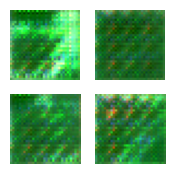

Epoch 28/1000: 100%|██████████| 50/50 [00:05<00:00,  8.51step/s]


Generator Loss: 15.803455352783203, Discriminator Loss: 1.7797895669937134


Epoch 29/1000: 100%|██████████| 50/50 [00:06<00:00,  8.89step/s]

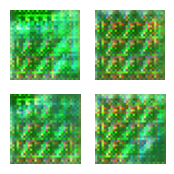

Epoch 29/1000: 100%|██████████| 50/50 [00:06<00:00,  8.05step/s]


Generator Loss: 12.4388427734375, Discriminator Loss: 3.9998514652252197


Epoch 30/1000:  98%|█████████▊| 49/50 [00:05<00:00,  7.80step/s]

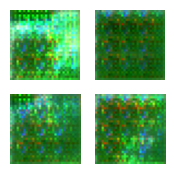

Epoch 30/1000: 100%|██████████| 50/50 [00:05<00:00,  8.54step/s]


Generator Loss: 12.755593299865723, Discriminator Loss: 2.9936907291412354


Epoch 31/1000:  98%|█████████▊| 49/50 [00:05<00:00,  8.15step/s]

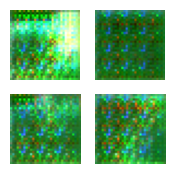

Epoch 31/1000: 100%|██████████| 50/50 [00:05<00:00,  8.38step/s]


Generator Loss: 10.988968849182129, Discriminator Loss: 1.7748122215270996


Epoch 32/1000:  98%|█████████▊| 49/50 [00:05<00:00,  8.56step/s]

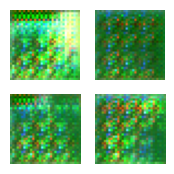

Epoch 32/1000: 100%|██████████| 50/50 [00:05<00:00,  8.49step/s]


Generator Loss: 12.472294807434082, Discriminator Loss: 2.0222740173339844


Epoch 33/1000: 100%|██████████| 50/50 [00:05<00:00, 11.99step/s]

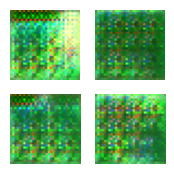

Epoch 33/1000: 100%|██████████| 50/50 [00:05<00:00,  9.08step/s]


Generator Loss: 10.967942237854004, Discriminator Loss: 1.8301113843917847


Epoch 34/1000:  98%|█████████▊| 49/50 [00:05<00:00,  8.40step/s]

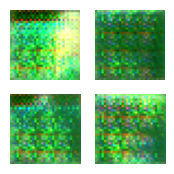

Epoch 34/1000: 100%|██████████| 50/50 [00:06<00:00,  8.25step/s]


Generator Loss: 9.186189651489258, Discriminator Loss: 2.0619308948516846


Epoch 35/1000: 100%|██████████| 50/50 [00:05<00:00,  9.28step/s]

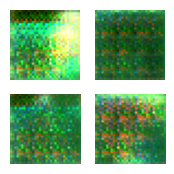

Epoch 35/1000: 100%|██████████| 50/50 [00:05<00:00,  8.52step/s]


Generator Loss: 9.308662414550781, Discriminator Loss: 1.6260398626327515


Epoch 36/1000:  98%|█████████▊| 49/50 [00:04<00:00, 11.02step/s]

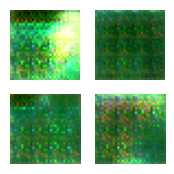

Epoch 36/1000: 100%|██████████| 50/50 [00:05<00:00,  9.53step/s]


Generator Loss: 8.98922348022461, Discriminator Loss: 1.5789856910705566


Epoch 37/1000: 100%|██████████| 50/50 [00:05<00:00,  7.50step/s]

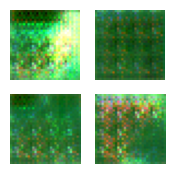

Epoch 37/1000: 100%|██████████| 50/50 [00:05<00:00,  9.35step/s]


Generator Loss: 10.15793514251709, Discriminator Loss: 1.2449301481246948


Epoch 38/1000: 100%|██████████| 50/50 [00:04<00:00,  9.34step/s]

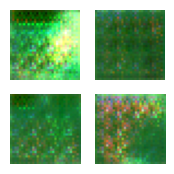

Epoch 38/1000: 100%|██████████| 50/50 [00:05<00:00,  9.73step/s]


Generator Loss: 9.451526641845703, Discriminator Loss: 1.6399439573287964


Epoch 39/1000: 100%|██████████| 50/50 [00:05<00:00,  9.77step/s]

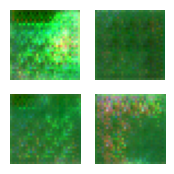

Epoch 39/1000: 100%|██████████| 50/50 [00:05<00:00,  9.16step/s]


Generator Loss: 8.653592109680176, Discriminator Loss: 1.689304232597351


Epoch 40/1000: 100%|██████████| 50/50 [00:05<00:00,  9.24step/s]

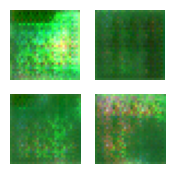

Epoch 40/1000: 100%|██████████| 50/50 [00:05<00:00,  9.49step/s]


Generator Loss: 8.082169532775879, Discriminator Loss: 1.5829555988311768


Epoch 41/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.58step/s]

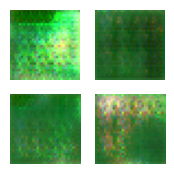

Epoch 41/1000: 100%|██████████| 50/50 [00:05<00:00,  9.95step/s]


Generator Loss: 7.830816745758057, Discriminator Loss: 1.5202893018722534


Epoch 42/1000: 100%|██████████| 50/50 [00:04<00:00,  9.06step/s]

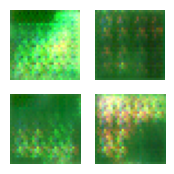

Epoch 42/1000: 100%|██████████| 50/50 [00:05<00:00,  9.93step/s]


Generator Loss: 7.334356784820557, Discriminator Loss: 1.468961238861084


Epoch 43/1000: 100%|██████████| 50/50 [00:04<00:00, 10.87step/s]

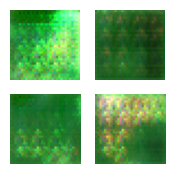

Epoch 43/1000: 100%|██████████| 50/50 [00:04<00:00, 10.72step/s]


Generator Loss: 6.916253089904785, Discriminator Loss: 1.3789416551589966


Epoch 44/1000: 100%|██████████| 50/50 [00:05<00:00,  9.18step/s]

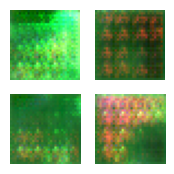

Epoch 44/1000: 100%|██████████| 50/50 [00:05<00:00,  9.43step/s]


Generator Loss: 6.959834098815918, Discriminator Loss: 1.3482964038848877


Epoch 45/1000: 100%|██████████| 50/50 [00:05<00:00,  7.99step/s]

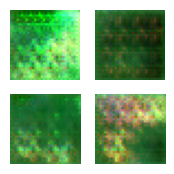

Epoch 45/1000: 100%|██████████| 50/50 [00:05<00:00,  9.35step/s]


Generator Loss: 7.095175743103027, Discriminator Loss: 1.8125497102737427


Epoch 46/1000: 100%|██████████| 50/50 [00:04<00:00, 11.64step/s]

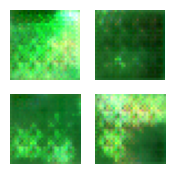

Epoch 46/1000: 100%|██████████| 50/50 [00:04<00:00, 10.26step/s]


Generator Loss: 5.714214324951172, Discriminator Loss: 1.0578416585922241


Epoch 47/1000: 100%|██████████| 50/50 [00:05<00:00,  8.53step/s]

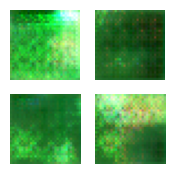

Epoch 47/1000: 100%|██████████| 50/50 [00:05<00:00,  9.26step/s]


Generator Loss: 5.625053882598877, Discriminator Loss: 1.26365327835083


Epoch 48/1000: 100%|██████████| 50/50 [00:04<00:00,  9.41step/s]

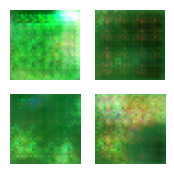

Epoch 48/1000: 100%|██████████| 50/50 [00:05<00:00,  9.51step/s]


Generator Loss: 5.268674850463867, Discriminator Loss: 1.3158180713653564


Epoch 49/1000: 100%|██████████| 50/50 [00:05<00:00,  9.10step/s]

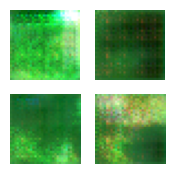

Epoch 49/1000: 100%|██████████| 50/50 [00:05<00:00,  9.04step/s]


Generator Loss: 5.0087080001831055, Discriminator Loss: 1.2293435335159302


Epoch 50/1000: 100%|██████████| 50/50 [00:05<00:00,  7.34step/s]

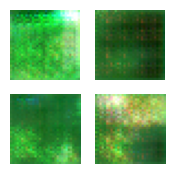

Epoch 50/1000: 100%|██████████| 50/50 [00:05<00:00,  8.91step/s]


Generator Loss: 4.738307952880859, Discriminator Loss: 1.178664207458496


Epoch 51/1000: 100%|██████████| 50/50 [00:05<00:00,  9.20step/s]

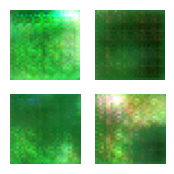

Epoch 51/1000: 100%|██████████| 50/50 [00:05<00:00,  9.68step/s]


Generator Loss: 4.603417873382568, Discriminator Loss: 1.1808092594146729


Epoch 52/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.29step/s]

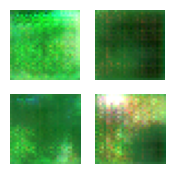

Epoch 52/1000: 100%|██████████| 50/50 [00:05<00:00,  9.72step/s]


Generator Loss: 4.212004661560059, Discriminator Loss: 1.1601228713989258


Epoch 53/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.23step/s]

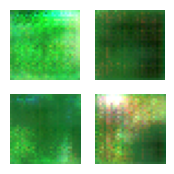

Epoch 53/1000: 100%|██████████| 50/50 [00:05<00:00,  9.24step/s]


Generator Loss: 3.830259084701538, Discriminator Loss: 1.2132766246795654


Epoch 54/1000: 100%|██████████| 50/50 [00:05<00:00,  9.44step/s]

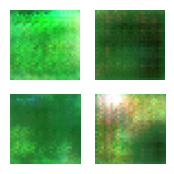

Epoch 54/1000: 100%|██████████| 50/50 [00:05<00:00,  8.89step/s]


Generator Loss: 3.734187602996826, Discriminator Loss: 1.126426100730896


Epoch 55/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.70step/s]

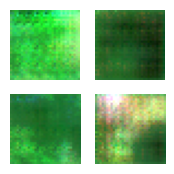

Epoch 55/1000: 100%|██████████| 50/50 [00:05<00:00,  8.98step/s]


Generator Loss: 3.7276132106781006, Discriminator Loss: 1.1306148767471313


Epoch 56/1000: 100%|██████████| 50/50 [00:05<00:00,  9.00step/s]

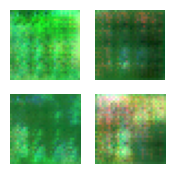

Epoch 56/1000: 100%|██████████| 50/50 [00:05<00:00,  9.54step/s]


Generator Loss: 3.5011911392211914, Discriminator Loss: 1.4795806407928467


Epoch 57/1000: 100%|██████████| 50/50 [00:05<00:00,  9.05step/s]

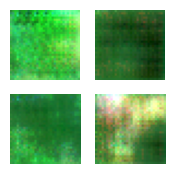

Epoch 57/1000: 100%|██████████| 50/50 [00:05<00:00,  9.45step/s]


Generator Loss: 3.4742705821990967, Discriminator Loss: 1.125136137008667


Epoch 58/1000: 100%|██████████| 50/50 [00:04<00:00, 10.16step/s]

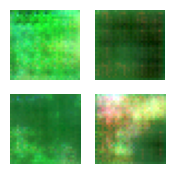

Epoch 58/1000: 100%|██████████| 50/50 [00:04<00:00, 10.09step/s]


Generator Loss: 3.555945634841919, Discriminator Loss: 1.0324584245681763


Epoch 59/1000: 100%|██████████| 50/50 [00:04<00:00, 11.16step/s]

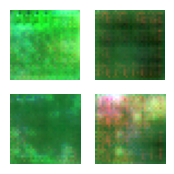

Epoch 59/1000: 100%|██████████| 50/50 [00:04<00:00, 10.40step/s]


Generator Loss: 3.257974624633789, Discriminator Loss: 1.2117893695831299


Epoch 60/1000: 100%|██████████| 50/50 [00:04<00:00,  9.23step/s]

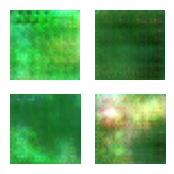

Epoch 60/1000: 100%|██████████| 50/50 [00:05<00:00,  9.82step/s]


Generator Loss: 3.4483306407928467, Discriminator Loss: 1.0618232488632202


Epoch 61/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.28step/s]

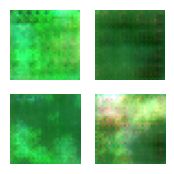

Epoch 61/1000: 100%|██████████| 50/50 [00:05<00:00,  9.52step/s]


Generator Loss: 3.479036331176758, Discriminator Loss: 1.0308853387832642


Epoch 62/1000: 100%|██████████| 50/50 [00:04<00:00,  9.01step/s]

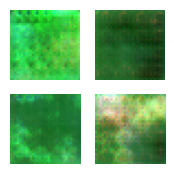

Epoch 62/1000: 100%|██████████| 50/50 [00:05<00:00,  9.94step/s]


Generator Loss: 3.483316659927368, Discriminator Loss: 1.0544514656066895


Epoch 63/1000: 100%|██████████| 50/50 [00:04<00:00,  9.70step/s]

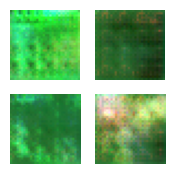

Epoch 63/1000: 100%|██████████| 50/50 [00:05<00:00,  9.83step/s]


Generator Loss: 3.070497512817383, Discriminator Loss: 1.1080838441848755


Epoch 64/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.61step/s]

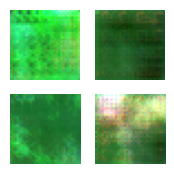

Epoch 64/1000: 100%|██████████| 50/50 [00:05<00:00,  9.96step/s]


Generator Loss: 2.8356409072875977, Discriminator Loss: 1.039817214012146


Epoch 65/1000: 100%|██████████| 50/50 [00:04<00:00,  9.85step/s]

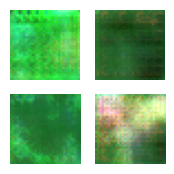

Epoch 65/1000: 100%|██████████| 50/50 [00:04<00:00, 10.35step/s]


Generator Loss: 2.9891655445098877, Discriminator Loss: 1.1301056146621704


Epoch 66/1000: 100%|██████████| 50/50 [00:04<00:00, 10.70step/s]

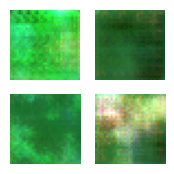

Epoch 66/1000: 100%|██████████| 50/50 [00:04<00:00, 10.54step/s]


Generator Loss: 2.9485137462615967, Discriminator Loss: 0.9936866164207458


Epoch 67/1000: 100%|██████████| 50/50 [00:04<00:00, 10.89step/s]

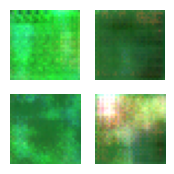

Epoch 67/1000: 100%|██████████| 50/50 [00:04<00:00, 10.16step/s]


Generator Loss: 2.7595555782318115, Discriminator Loss: 1.084895133972168


Epoch 68/1000: 100%|██████████| 50/50 [00:04<00:00, 10.85step/s]

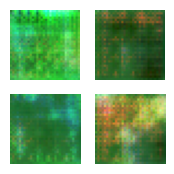

Epoch 68/1000: 100%|██████████| 50/50 [00:04<00:00, 10.87step/s]


Generator Loss: 3.5469613075256348, Discriminator Loss: 3.0022225379943848


Epoch 69/1000:  98%|█████████▊| 49/50 [00:04<00:00, 11.01step/s]

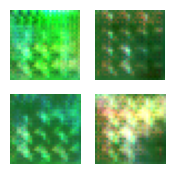

Epoch 69/1000: 100%|██████████| 50/50 [00:04<00:00, 10.58step/s]


Generator Loss: 2.5082039833068848, Discriminator Loss: 1.1811491250991821


Epoch 70/1000: 100%|██████████| 50/50 [00:05<00:00,  7.60step/s]

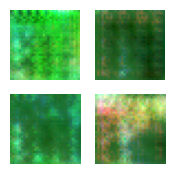

Epoch 70/1000: 100%|██████████| 50/50 [00:05<00:00,  8.88step/s]


Generator Loss: 2.726102590560913, Discriminator Loss: 1.0200066566467285


Epoch 71/1000: 100%|██████████| 50/50 [00:05<00:00,  9.36step/s]

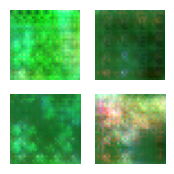

Epoch 71/1000: 100%|██████████| 50/50 [00:05<00:00,  8.79step/s]


Generator Loss: 2.868659019470215, Discriminator Loss: 1.060956597328186


Epoch 72/1000: 100%|██████████| 50/50 [00:05<00:00,  8.56step/s]

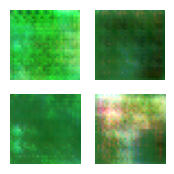

Epoch 72/1000: 100%|██████████| 50/50 [00:06<00:00,  8.30step/s]


Generator Loss: 2.663194179534912, Discriminator Loss: 1.033888339996338


Epoch 73/1000: 100%|██████████| 50/50 [00:05<00:00,  8.84step/s]

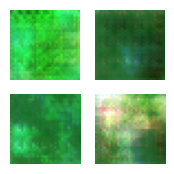

Epoch 73/1000: 100%|██████████| 50/50 [00:05<00:00,  8.85step/s]


Generator Loss: 2.565793037414551, Discriminator Loss: 1.071508765220642


Epoch 74/1000: 100%|██████████| 50/50 [00:05<00:00,  7.65step/s]

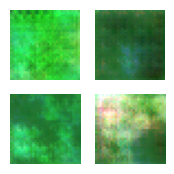

Epoch 74/1000: 100%|██████████| 50/50 [00:06<00:00,  8.31step/s]


Generator Loss: 2.353558301925659, Discriminator Loss: 1.0532164573669434


Epoch 75/1000: 100%|██████████| 50/50 [00:05<00:00,  8.23step/s]

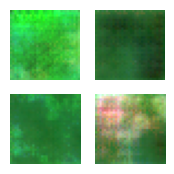

Epoch 75/1000: 100%|██████████| 50/50 [00:06<00:00,  8.22step/s]


Generator Loss: 2.3290364742279053, Discriminator Loss: 1.1122347116470337


Epoch 76/1000: 100%|██████████| 50/50 [00:06<00:00,  8.98step/s]

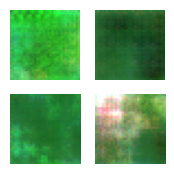

Epoch 76/1000: 100%|██████████| 50/50 [00:06<00:00,  7.71step/s]


Generator Loss: 2.4088938236236572, Discriminator Loss: 1.0509952306747437


Epoch 77/1000: 100%|██████████| 50/50 [00:06<00:00,  8.49step/s]

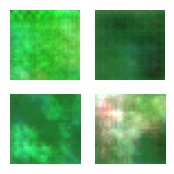

Epoch 77/1000: 100%|██████████| 50/50 [00:06<00:00,  7.52step/s]


Generator Loss: 2.3993492126464844, Discriminator Loss: 1.0788373947143555


Epoch 78/1000:  98%|█████████▊| 49/50 [00:05<00:00,  9.08step/s]

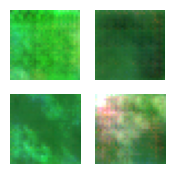

Epoch 78/1000: 100%|██████████| 50/50 [00:06<00:00,  8.29step/s]


Generator Loss: 2.4020938873291016, Discriminator Loss: 1.1261990070343018


Epoch 79/1000:  98%|█████████▊| 49/50 [00:05<00:00,  8.56step/s]

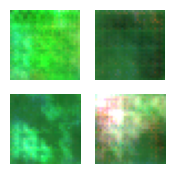

Epoch 79/1000: 100%|██████████| 50/50 [00:05<00:00,  8.94step/s]


Generator Loss: 2.3439226150512695, Discriminator Loss: 1.1989734172821045


Epoch 80/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.55step/s]

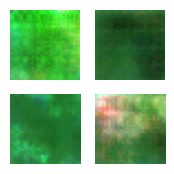

Epoch 80/1000: 100%|██████████| 50/50 [00:05<00:00,  9.51step/s]


Generator Loss: 2.3297855854034424, Discriminator Loss: 1.0897266864776611


Epoch 81/1000: 100%|██████████| 50/50 [00:05<00:00,  9.36step/s]

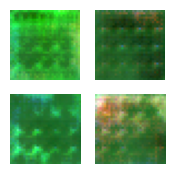

Epoch 81/1000: 100%|██████████| 50/50 [00:05<00:00,  9.00step/s]


Generator Loss: 2.269392490386963, Discriminator Loss: 1.2713119983673096


Epoch 82/1000:  98%|█████████▊| 49/50 [00:04<00:00,  9.29step/s]

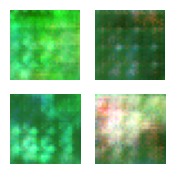

Epoch 82/1000: 100%|██████████| 50/50 [00:05<00:00,  9.64step/s]


Generator Loss: 2.517119884490967, Discriminator Loss: 1.115172028541565


Epoch 83/1000: 100%|██████████| 50/50 [00:05<00:00,  9.28step/s]

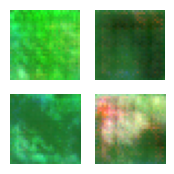

Epoch 83/1000: 100%|██████████| 50/50 [00:05<00:00,  9.23step/s]


Generator Loss: 2.2294962406158447, Discriminator Loss: 1.1576809883117676


Epoch 84/1000: 100%|██████████| 50/50 [00:05<00:00,  9.36step/s]

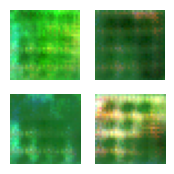

Epoch 84/1000: 100%|██████████| 50/50 [00:05<00:00,  8.68step/s]


Generator Loss: 3.158864974975586, Discriminator Loss: 5.364141464233398


Epoch 85/1000: 100%|██████████| 50/50 [00:04<00:00, 10.06step/s]

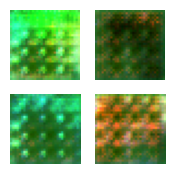

Epoch 85/1000: 100%|██████████| 50/50 [00:04<00:00, 10.27step/s]


Generator Loss: 2.43770432472229, Discriminator Loss: 1.8143949508666992


Epoch 86/1000:  98%|█████████▊| 49/50 [00:04<00:00,  9.70step/s]

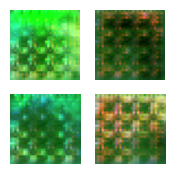

Epoch 86/1000: 100%|██████████| 50/50 [00:04<00:00, 10.00step/s]


Generator Loss: 2.279360771179199, Discriminator Loss: 1.4795618057250977


Epoch 87/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.89step/s]

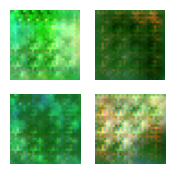

Epoch 87/1000: 100%|██████████| 50/50 [00:05<00:00,  9.76step/s]


Generator Loss: 1.9817347526550293, Discriminator Loss: 1.0577292442321777


Epoch 88/1000:  98%|█████████▊| 49/50 [00:04<00:00, 10.88step/s]

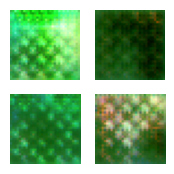

Epoch 88/1000: 100%|██████████| 50/50 [00:05<00:00,  9.89step/s]


Generator Loss: 2.452704668045044, Discriminator Loss: 1.0839735269546509


Epoch 89/1000: 100%|██████████| 50/50 [00:04<00:00, 10.24step/s]

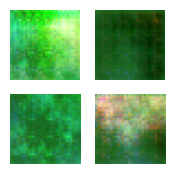

Epoch 89/1000: 100%|██████████| 50/50 [00:04<00:00, 10.01step/s]


Generator Loss: 2.1679608821868896, Discriminator Loss: 1.0610549449920654


Epoch 90/1000: 100%|██████████| 50/50 [00:05<00:00,  9.33step/s]

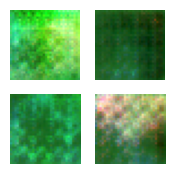

Epoch 90/1000: 100%|██████████| 50/50 [00:05<00:00,  9.17step/s]


Generator Loss: 2.074014663696289, Discriminator Loss: 1.1914176940917969


Epoch 91/1000: 100%|██████████| 50/50 [00:04<00:00,  9.02step/s]

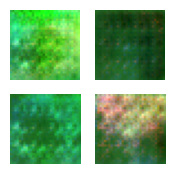

Epoch 91/1000: 100%|██████████| 50/50 [00:04<00:00, 10.21step/s]


Generator Loss: 2.0620617866516113, Discriminator Loss: 1.102246880531311


Epoch 92/1000: 100%|██████████| 50/50 [00:05<00:00, 10.57step/s]

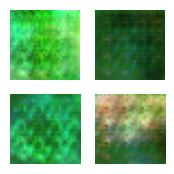

Epoch 92/1000: 100%|██████████| 50/50 [00:05<00:00,  9.28step/s]


Generator Loss: 2.176748514175415, Discriminator Loss: 1.0286977291107178


Epoch 93/1000:  98%|█████████▊| 49/50 [00:04<00:00,  9.95step/s]

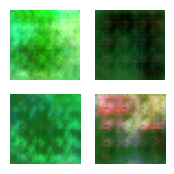

Epoch 93/1000: 100%|██████████| 50/50 [00:05<00:00,  9.60step/s]


Generator Loss: 2.237349510192871, Discriminator Loss: 1.0191175937652588


Epoch 94/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.26step/s]

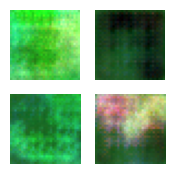

Epoch 94/1000: 100%|██████████| 50/50 [00:05<00:00,  9.14step/s]


Generator Loss: 2.088486433029175, Discriminator Loss: 1.0676379203796387


Epoch 95/1000:  98%|█████████▊| 49/50 [00:05<00:00, 10.67step/s]

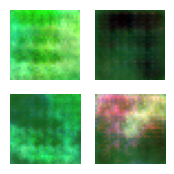

Epoch 95/1000: 100%|██████████| 50/50 [00:05<00:00,  9.44step/s]


Generator Loss: 1.9685009717941284, Discriminator Loss: 1.0865380764007568


Epoch 96/1000: 100%|██████████| 50/50 [00:04<00:00,  9.45step/s]

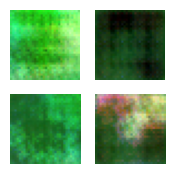

Epoch 96/1000: 100%|██████████| 50/50 [00:05<00:00,  9.45step/s]


Generator Loss: 2.0876922607421875, Discriminator Loss: 1.0551124811172485


Epoch 97/1000:  98%|█████████▊| 49/50 [00:04<00:00, 11.59step/s]

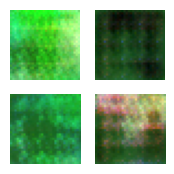

Epoch 97/1000: 100%|██████████| 50/50 [00:04<00:00, 10.15step/s]


Generator Loss: 1.785832405090332, Discriminator Loss: 1.0313948392868042


Epoch 98/1000: 100%|██████████| 50/50 [00:05<00:00, 10.05step/s]

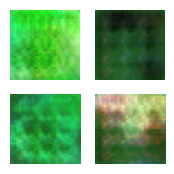

Epoch 98/1000: 100%|██████████| 50/50 [00:05<00:00,  9.62step/s]


Generator Loss: 1.922715425491333, Discriminator Loss: 1.0394541025161743


Epoch 99/1000: 100%|██████████| 50/50 [00:05<00:00,  9.80step/s]

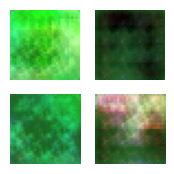

Epoch 99/1000: 100%|██████████| 50/50 [00:05<00:00,  9.67step/s]


Generator Loss: 1.8657934665679932, Discriminator Loss: 1.0789779424667358


Epoch 100/1000: 100%|██████████| 50/50 [00:04<00:00,  9.52step/s]

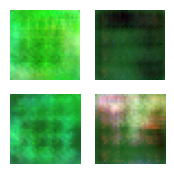

Epoch 100/1000: 100%|██████████| 50/50 [00:05<00:00,  9.69step/s]


Generator Loss: 1.867652416229248, Discriminator Loss: 1.0049740076065063


Epoch 101/1000: 100%|██████████| 50/50 [00:05<00:00, 10.61step/s]

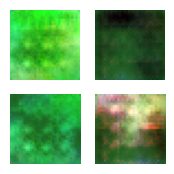

Epoch 101/1000: 100%|██████████| 50/50 [00:05<00:00,  9.67step/s]


Generator Loss: 1.6521910429000854, Discriminator Loss: 1.1056922674179077


Epoch 102/1000: 100%|██████████| 50/50 [00:04<00:00, 11.12step/s]

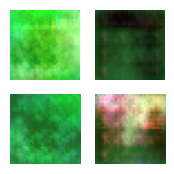

Epoch 102/1000: 100%|██████████| 50/50 [00:05<00:00,  9.73step/s]


Generator Loss: 1.6931685209274292, Discriminator Loss: 1.101728916168213


Epoch 103/1000: 100%|██████████| 50/50 [00:05<00:00,  9.43step/s]

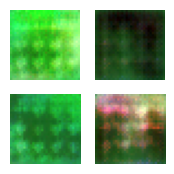

Epoch 103/1000: 100%|██████████| 50/50 [00:05<00:00,  9.27step/s]


Generator Loss: 1.6467550992965698, Discriminator Loss: 1.0806351900100708


Epoch 104/1000: 100%|██████████| 50/50 [00:05<00:00,  9.48step/s]

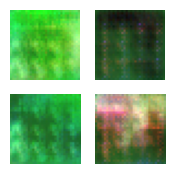

Epoch 104/1000: 100%|██████████| 50/50 [00:05<00:00,  9.63step/s]


Generator Loss: 1.5105608701705933, Discriminator Loss: 1.1116989850997925


Epoch 105/1000:  98%|█████████▊| 49/50 [00:05<00:00,  9.79step/s]

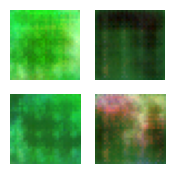

Epoch 105/1000: 100%|██████████| 50/50 [00:05<00:00,  9.26step/s]


Generator Loss: 1.5295681953430176, Discriminator Loss: 1.1879271268844604


Epoch 106/1000: 100%|██████████| 50/50 [00:05<00:00, 10.20step/s]

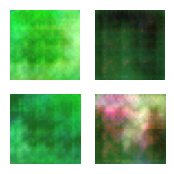

Epoch 106/1000: 100%|██████████| 50/50 [00:05<00:00,  9.12step/s]


Generator Loss: 1.3830459117889404, Discriminator Loss: 1.1309876441955566


Epoch 107/1000: 100%|██████████| 50/50 [00:04<00:00,  9.43step/s]

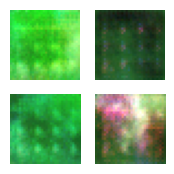

Epoch 107/1000: 100%|██████████| 50/50 [00:05<00:00, 10.00step/s]


Generator Loss: 1.4234025478363037, Discriminator Loss: 1.1557707786560059


Epoch 108/1000: 100%|██████████| 50/50 [00:05<00:00,  9.43step/s]

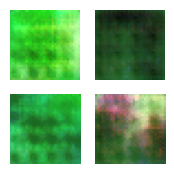

Epoch 108/1000: 100%|██████████| 50/50 [00:05<00:00,  9.52step/s]


Generator Loss: 1.4097462892532349, Discriminator Loss: 1.1314729452133179


Epoch 109/1000: 100%|██████████| 50/50 [00:05<00:00,  8.73step/s]

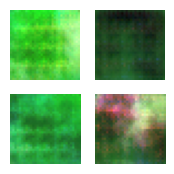

Epoch 109/1000: 100%|██████████| 50/50 [00:05<00:00,  9.28step/s]


Generator Loss: 1.3965983390808105, Discriminator Loss: 1.1431716680526733


Epoch 110/1000:  88%|████████▊ | 44/50 [00:04<00:00, 10.37step/s]

In [ ]:
train(image_generator, epochs=1000,batch_size=batch_size)

In [ ]:
seed = tf.random.normal([num_examples_to_generate, 100])
predictions = generator(seed , training=False)

# Adjust the figure size if needed
fig = plt.figure(figsize=(4, 4))  # You may want to make this bigger if the images are too small

# Limit to display the first 4 images
for i in range(4):  # Change from `predictions.shape[0]` to `4`
    plt.subplot(2, 2, i+1)  # Arrange in a 2x2 grid
    # Rescale the pixel values to the [0, 255] range and remove the last dimension
    image = np.squeeze(np.clip(predictions[i] * 127.5 + 127.5 , 0, 255).astype(np.uint8))
    plt.imshow(image, cmap='gray')  # Show the image in grayscale
    plt.axis('off')

plt.show()

In [ ]:
generator.save('generator_erizos.h5')

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generar_imagen_con_objetos(num_min_objetos, num_max_objetos, proporciones, tamanos, tamano_imagen=512):
    """
    Genera una imagen cuadrada con objetos representados por rectángulos de colores sin superposición.
    Devuelve la figura, y una lista de tuplas que incluyen la clase y las coordenadas de los objetos.

    :param num_min_objetos: Número mínimo de objetos a generar.
    :param num_max_objetos: Número máximo de objetos a generar.
    :param proporciones: Diccionario con la proporción de cada tipo de objeto.
    :param tamanos: Diccionario con rangos de tamaño (min, max) para cada tipo de objeto.
    :param tamano_imagen: Tamaño de la imagen (se asume cuadrada).
    :return: La figura y las coordenadas con clases de los objetos.
    """
    # Colores para cada tipo de objeto
    colores = {'erizo': 'red', 'pepino': 'yellow', 'vieira': 'white'}

    # Crear figura cuadrada
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, tamano_imagen)
    ax.set_ylim(0, tamano_imagen)

    # Fondo azul para la imagen
    ax.set_facecolor('blue')

    # Número aleatorio de objetos a generar
    num_objetos = random.randint(num_min_objetos, num_max_objetos)
    objetos = []

    while len(objetos) < num_objetos:
        tipo = random.choices(list(proporciones.keys()), weights=list(proporciones.values()))[0]
        min_tamano, max_tamano = tamanos[tipo]
        ancho = random.randint(min_tamano, max_tamano)
        alto = random.randint(min_tamano, max_tamano)
        xmin = random.randint(0, tamano_imagen - ancho)
        ymin = random.randint(0, tamano_imagen - alto)

        nuevo_objeto = (xmin, ymin, xmin + ancho, ymin + alto)

        # Comprobar superposición
        if not any(overlap(nuevo_objeto, existente[1]) for existente in objetos):
            objetos.append((tipo, nuevo_objeto))

            # Dibujar rectángulo
            rect = patches.Rectangle((xmin, ymin), ancho, alto, linewidth=1, edgecolor='black', facecolor=colores[tipo])
            ax.add_patch(rect)

    plt.show()
    return fig, objetos

def overlap(obj1, obj2):
    """
    Comprueba si dos objetos (definidos por sus coordenadas) se superponen.

    :param obj1: Coordenadas del primer objeto (xmin, ymin, xmax, ymax).
    :param obj2: Coordenadas del segundo objeto (xmin, ymin, xmax, ymax).
    :return: True si hay superposición, False en caso contrario.
    """
    return not (obj1[2] <= obj2[0] or obj1[0] >= obj2[2] or obj1[3] <= obj2[1] or obj1[1] >= obj2[3])

# Ejemplo de uso
num_min_objetos = 5
num_max_objetos = 20
proporciones = {'erizo': 0.4, 'pepino': 0.3, 'vieira': 0.3}
tamanos = {'erizo': (32, 64), 'pepino': (32, 64), 'vieira': (20, 40)}

figura, objetos = generar_imagen_con_objetos(num_min_objetos, num_max_objetos, proporciones, tamanos)
for objeto in objetos:
    print(objeto)
